# Laboratory 2.2: Source Localization

**Objectives:** 

- Create a graph using a stochastic block model (SBM).
- Implement a graph neural network (GNN) to determine which community originated a certain graph signal.
- Analyse the effect of varying levels of noise and number of communities.

**Completion requirements:**

By the end of this notebook, you should have:
- Implemented all code cells for:
  - defining a GNN-model. 
  - training the GNN-model
  - assesing the performance of the GNN-model.
- Answered the analysis questions on each section. 

## 🔙 Background

Graphs such as social networks can be divided in communities based on common traits. In several tasks, we are interested in finding the source of the information. In other words, which community is responsible for generating a fake news, outbreak, epidemics, or rumor.
To determine where a signal originated from we can use graph based tools such as GNNs.
In the source localization problem, we have to estimate which community $c$ originated the diffusion, by observing graph signals and knowing the topology.

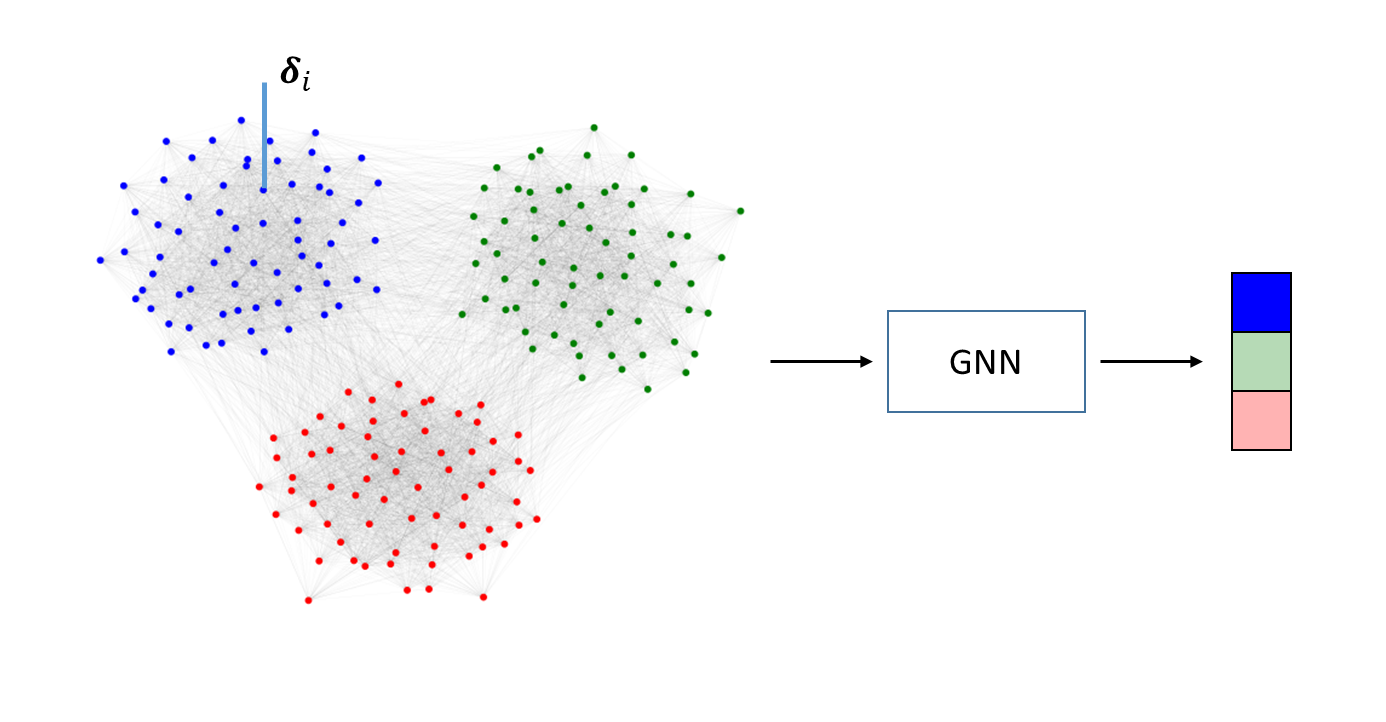


## ⛔ Problem definition 

In this notebook, you are asked to create a graph neural network (GNN) to determine the community which originated a certain graph signal.
This problem is a supervised graph signal classification given a training set of input-output pairs $(\mathbf{x}, c)$, where $c$ is the community that has originated the diffusion and $\mathbf{x}$ is the graph signal. 
The output can be given by a one-hot vector on the number of communities, and we can use a cross-entropy loss for training.

<u> Dataset details </u>

In this laboratory, we consider a synthetic dataset created via a stochastic block model graph with $C$ communities. We generate the data by diffusing unitary signals from different source nodes and sampling it after a certain number of diffusion steps. Your task will then be to determine from which community the signal is originated from.

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

To run this notebook you need to have installed the following packages:
- Numpy
- NetworkX
- Pytorch
- Pytorch geometric

In [49]:
import torch
import networkx as nx
import numpy as np
from torch.nn.functional import one_hot

from torch_geometric.utils import from_networkx

## Create a graph using a stochastic block model (SBM)
First of all you need to create a function that generates a graph with $C$ number of communities using a stochastic block model.
The function should have as arguments the number of nodes of the graph, the number of communities, and the probabilties of creating an edge inside a community and among different communities

In [154]:
def generate_sbm_graph(num_nodes, num_communities=2, 
                       intra_prob=0.8, inter_prob=0.1, seed=42):
  """
  Description:
  
  This function generates a graph using the Stochastic Block Model (SBM), 
  which assumes that nodes in a graph belong to one or more communities, 
  and edges between nodes are generated probabilistically based on the community assignments.

  Parameters:

  num_nodes (int): The total number of nodes in the generated graph.
  num_communities (int): The desired number of communities in the generated graph.
  intra_prob (float): The probability of an edge existing between two nodes within the same community.
  inter_prob (float): The probability of an edge existing between two nodes in different communities.
  seed (int): The seed for the random number generator used in generating the graph.

  Returns:

  adjacency_matrix (numpy.ndarray): A 2D array representing the adjacency matrix of the generated graph. 
    The entry at index (i, j) represents the presence (1) or absence (0) of an edge between nodes i and j.
  labels (numpy.ndarray): A 1D numpy array representing the community assignments of each node in the generated graph. 
    The entry at index i represents the community assignment of node i, which is an integer ranging from 0 to num_communities-1.

  Note:
  Be sure to balance the number of nodes in each community.
  """
  np.random.seed(seed)
  sizes = [num_nodes // num_communities] * num_communities  # Assuming the number of nodes can be divided equally among communities
  sizes[-1] = sizes[-1] + (num_nodes % num_communities)

  p_matrix = [[intra_prob if i == j else inter_prob for j in range(num_communities)] for i in range(num_communities)]
  g = nx.stochastic_block_model(sizes, p_matrix, seed=seed)

  # Extracting adjacency matrix and community labels
  adjacency_matrix = nx.adjacency_matrix(g).todense()
  labels = np.empty(num_nodes, dtype=np.int32)
  for i, nodes in enumerate(g.graph['partition']):
      labels[list(nodes)] = i

  return adjacency_matrix, labels


In [155]:
num_nodes = 200 # Number of nodes
num_communities = 3 # Number of communities

intra_prob = 0.7 # Probability of drawing edges intra communities
inter_prob = 0.2 # Probability of drawing edges inter communities

adjacency_matrix, labels = generate_sbm_graph(num_nodes, num_communities, intra_prob, inter_prob, seed=42)

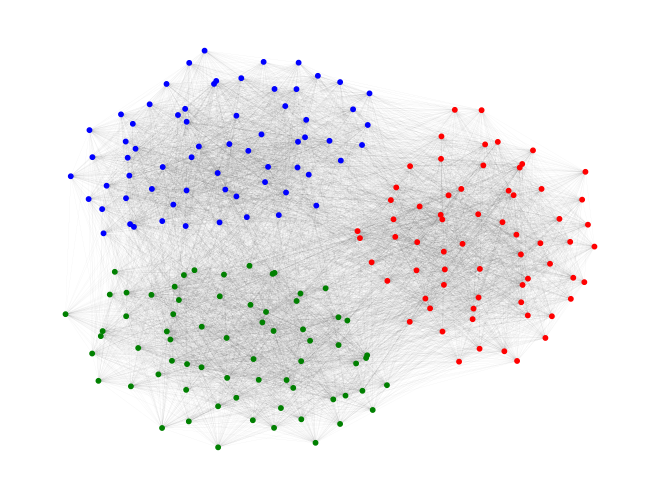

In [156]:
color_mapping=['blue','red','green']
color_map = [color_mapping[i] for i in labels]

# Convert adjacency matrix to networkx graph
graph = nx.from_numpy_array(adjacency_matrix)

nx.draw(graph, 
        node_color=color_map,
        node_size=10, width=0.01)

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

* Can you clearly identify the communities? If not, why?



#### Answers:
Yes, I can clearly identify the communities.

When the intra and inter probabilities are close to each other the communities start to merge. 
Otherwise, the networkx plotting tool should clearly highlight the different communities.

## Diffuse the signal from a source node and sample it at a random time
After generating the SBM graph, you are asked to diffuse a unitary node signal following this equation:

$\mathbf{x}_t = \mathbf{S}^t \boldsymbol{\delta}_i + \boldsymbol{\epsilon}_t$

where $\mathbf{x}_t$ is the diffused graph signal $\mathbf{S}$ is the graph shift operator, $\boldsymbol{\delta}_i$ is a graph signal that has a 1 in node $i$ and 0 elsewhere, and $\boldsymbol{\epsilon}_t$ is a Gaussian noise with zero mean and std. deviation $\sigma$. This equation propagates the graph signal $\boldsymbol{\delta}_i$ for $t$ diffusion steps.

Write a function that implements the above equation, given a graph, a source node, the noise standard deviation, and the number of diffusion steps.


In [190]:
def generate_diffusion(adjacency_matrix, source_node, n_diffusions, noise_std=0.01, seed=42):
  """
  Description:
  This function generates a dataset of diffused signals given a source node on a graph represented by an adjacency matrix. 
  The diffusion process is modeled as iteratively multiplying the signal vector with the normalized adjacency matrix, 
  and adding Gaussian noise at each iteration.

  Parameters:

  adjacency_matrix (numpy.ndarray): A 2D numpy array representing the adjacency matrix of the graph.
  source_node (int): Index of the source node from which the diffusion process starts.
  n_diffusions (int): Number of diffusion steps to perform.
  noise_std (float): Standard deviation of the Gaussian noise added at each diffusion step.
  seed (int): The seed for the random number generator used in generating the Gaussian noise.

  Returns:

  signal (torch.Tensor): A 1D tensor representing the final diffused signal after the specified number of diffusion steps. 
    The length of the array is equal to the number of nodes in the graph, 
    and the entry at index i represents the diffused signal value of node i.
  
  Note:
  
  The adjacency matrix is normalized by dividing it by the maximum eigenvalue to avoid exploding values.
  """


  # Normalize the adjacency matrix to avoid exploding values
  e, V = np.linalg.eigh(adjacency_matrix)
  e_max = np.max(e)
  adjacency_matrix = adjacency_matrix / e_max

  # Initialize the signal vector
  signal = np.zeros(adjacency_matrix.shape[0])
  signal[source_node] = 1

  # Perform the diffusion process
  for _ in range(n_diffusions):
      signal = adjacency_matrix @ signal  # Diffuse the signal
      signal += np.random.normal(0, noise_std, signal.shape)  # Add Gaussian noise

  return torch.from_numpy(signal) 

## 📚 Create database

Create a function that defines different instances of diffused graph signals, using for each instance a random source node and a random number of diffusion steps.

Afterwards, generate the dataset and split it into training, validation, and testing sets.

In [390]:
def create_dataset(total_samples, adjacency_matrix, labels, num_communities, maximum_diffusion_steps=10, noise_std=0.01):
  """
  Description:
  This function generates a dataset of diffused signals for a specified number of samples, given an adjacency matrix of a graph. 
  The diffusion process starts from randomly selected source nodes and is performed for a random number of diffusion steps. 
  The resulting dataset is returned as tensors of input signals (x) and corresponding labels (y).

  Parameters:

  total_samples (int): The total number of samples to generate in the dataset.
  adjacency_matrix (numpy.ndarray): A 2D array representing the adjacency matrix of the graph.
  maximum_diffusion_steps (int): The maximum number of diffusion steps to perform for each sample. 
    The actual number of diffusion steps is randomly selected for each sample from the range [0, maximum_diffusion_steps).
  noise_std (float): The standard deviation of the Gaussian noise added at each diffusion step.
  
  Returns:

  all_x (torch.Tensor): A 3D tensor representing the input signals (diffused signals) in the dataset [samples x N x 1].
  all_y (torch.Tensor): A 2D tensor representing the labels (one-hot encoded) corresponding to the community which originated the signal [samples x num_communities].
  """
  all_x = []
  all_y = []

  num_nodes = adjacency_matrix.shape[0]

  for _ in range(total_samples):
    # Select a random source node and a random number of diffusion steps
    source_node = np.random.randint(0, num_nodes)
    num_diffusions = np.random.randint(0, maximum_diffusion_steps)
    # Generate the diffused signal
    signal = generate_diffusion(adjacency_matrix, source_node, num_diffusions, noise_std)
      
    # Create the label: one-hot encoded vector indicating the community of the source node
    label = np.zeros(num_communities)
    label[labels[source_node]-1] = 1

    all_x.append(signal.unsqueeze(-1))  # Make it [N x 1]
    all_y.append(torch.from_numpy(label))

  return torch.stack(all_x), torch.stack(all_y)

In [204]:
train_size  = 200 # Number of training samples
val_size    = 50 # Number of validation samples
test_size   = 50 # Number of testing samples

total_samples = train_size + val_size + test_size

all_x, all_y = create_dataset(total_samples, adjacency_matrix, maximum_diffusion_steps=10, noise_std=0)

In [206]:
import random
from torch_geometric.data import Data


def create_train_val_test(graph, all_x, all_y, train_size, val_size, test_size):
  
  """
  This function splits the generated dataset into training, validation, and testing datasets 
  based on the specified sizes. 
  It creates separate datasets for each split, where each dataset consists of data objects with
  input signals (x) and labels (y) based on the generated diffused signals.

  Note:
  
  The training, validation, and testing datasets are returned as lists of PyTorch Geometric Data objects.
  """
  train_dataset = []
  val_dataset = []
  test_dataset = []
  # Convert the networkx graph to edge_index format for PyTorch Geometric
  edge_index = torch.tensor(list(graph.edges)).t().contiguous()
  indices = list(range(len(all_x)))
  random.shuffle(indices)
  for i in range(len(indices)):
    idx = indices[i]
    data = Data(x=all_x[idx], y=all_y[idx].unsqueeze(dim=0), edge_index=edge_index)
    if i < train_size:
       train_dataset.append(data)
    elif i < train_size + val_size:
       val_dataset.append(data)
    else:
       test_dataset.append(data)
       
  return train_dataset, val_dataset, test_dataset

In [212]:
train_dataset, val_dataset, test_dataset = create_train_val_test(graph, all_x, all_y, train_size, val_size, test_size)

#### Dataset sample

This is how one sample of your dataset should look like:

- **edge_index:** Graph connectivity in COO format with shape [2, num_edges]

- **x:** Input node features with shape [Nodes, Node features]. 
    The number of node features is 1 for for our case and it represents the value of the diffused graph signal

- **y:** Output graph signal, i.e. target feature. Shape [1, num_communities].

In [195]:
train_dataset[0]

Data(x=[200, 1], edge_index=[2, 7297], y=[1, 3])

## 💻 Model definition and training

**Instructions:**
Define a GNN model class, instantiate it, and train it.

The GNN takes as input the diffused node signal and returns the estimate of which community originated it.

In [196]:
from torch_geometric.nn import ChebConv
from torch_geometric.loader import DataLoader

import torch.nn as nn

In [373]:
from torch_geometric.nn import GCNConv, global_mean_pool

class Net(torch.nn.Module):    
    """
    Graph neural network (GNN) model for community detection.
    
    Args:
        num_communities (int): Number of communities in the graph.
        num_nodes (int): Number of nodes in the graph.
        hid_features (int): Number of hidden features in the GNN layers.
    """
    def __init__(self, num_communities, num_nodes, hid_features=16):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1, hid_features)
        self.conv2 = GCNConv(hid_features, hid_features)
        self.linear = nn.Linear(hid_features*num_nodes, num_communities)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index # x = [3200, 1]
        x = x.float()

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        
        x = x.reshape(data.y.shape[0], -1)
        x = self.linear(x)
        
        return x

#### Model instantiation

In [352]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = Net(num_communities, num_nodes, hid_features=16).to(device)

### 🏋🏽‍♀️Train a Graph Neural Network

Train your GNN model. 

Define the training and evaluation functions.

Pay attention to which loss function you are going to use.

#### Define the training and evaluation functions.

In [374]:
def train_epoch(model, loader, optimizer, device='cpu'):
  """
    Trains a neural network model for one epoch using the specified data loader and optimizer.

    Args:
        model (nn.Module): The neural network model to be trained.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the training data.
        optimizer (torch.optim.Optimizer): The PyTorch optimizer used for training the model.
        device (str): The device used for training the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """
  model.to(device)
  model.train()
  
  total_loss = 0
  for data in loader:  
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data)  
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out,torch.argmax(data.y, dim=1))
    loss.backward()  
    optimizer.step()
    total_loss += loss.item() * data.num_graphs 

  return total_loss / len(loader.dataset)

In [394]:
@torch.no_grad()
def evaluate_epoch(model, loader, device='cpu'):
    """
    Evaluates the performance of a trained neural network model on a dataset using the specified data loader.

    Args:
        model (nn.Module): The trained neural network model to be evaluated.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the evaluation data.
        device (str): The device used for evaluating the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """
    model.to(device)
    model.eval()
    
    total_loss = 0
    total_correct = 0
    for data in loader: 
        data = data.to(device) 
        out = model(data)  
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, torch.argmax(data.y, dim=1))
        total_loss += loss.item() * data.num_graphs 
        pred = torch.argmax(out, dim=1)
        gt = torch.argmax(data.y, dim=1)
        total_correct += (pred == gt).sum().item()

    return total_loss / len(loader.dataset), total_correct / len(loader.dataset) 

#### Define the DataLoaders and the optimizer

In [376]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

#### Train the model

In [380]:
epochs = 100
train_loss = []
val_loss = []
val_acc = []

for epoch in range(epochs):
    t_loss = train_epoch(model, train_loader, optimizer)
    train_loss.append(t_loss)
    v_loss, acc = evaluate_epoch(model, val_loader)
    val_loss.append(v_loss)
    val_acc.append(acc)
    print(f'Epoch {epoch} train loss: {t_loss} val loss: {v_loss} accuracy: {acc}')

Epoch 0 train loss: 0.8332468843460084 val loss: 0.8685609531402588 accuracy: 0.6
Epoch 1 train loss: 0.8326249575614929 val loss: 0.8751523208618164 accuracy: 0.5
Epoch 2 train loss: 0.8318951797485351 val loss: 0.8702810382843018 accuracy: 0.62
Epoch 3 train loss: 0.8508619832992553 val loss: 0.897617712020874 accuracy: 0.46
Epoch 4 train loss: 0.8316321015357971 val loss: 0.8715105247497559 accuracy: 0.54
Epoch 5 train loss: 0.8489486813545227 val loss: 0.8696417236328124 accuracy: 0.68
Epoch 6 train loss: 0.8525941729545593 val loss: 0.8964947366714477 accuracy: 0.46
Epoch 7 train loss: 0.8302335572242737 val loss: 0.8687489604949952 accuracy: 0.66
Epoch 8 train loss: 0.8446140766143799 val loss: 0.8929092144966125 accuracy: 0.46
Epoch 9 train loss: 0.8252517819404602 val loss: 0.867997407913208 accuracy: 0.54
Epoch 10 train loss: 0.8277297830581665 val loss: 0.8646865463256836 accuracy: 0.56
Epoch 11 train loss: 0.8301339769363403 val loss: 0.8666554927825928 accuracy: 0.56
Epoch 

## 📈 Results

#### Visualize loss and testing results

Plot the training and validation losses as a function of the epochs and analyse the performance of the network.

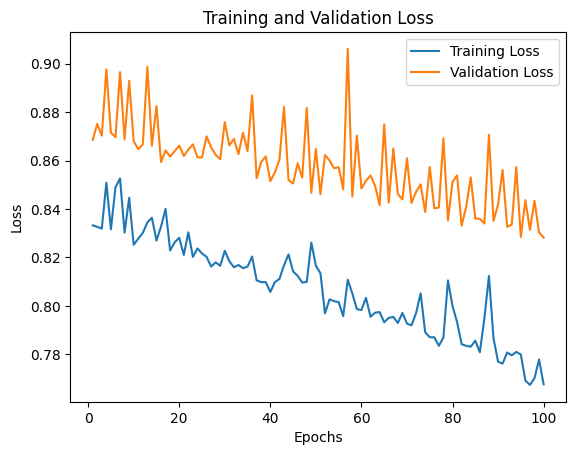

In [381]:
import matplotlib.pyplot as plt

epochs = range(1, 101)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

* What is the final testing accuracy? How does it relate to the training performance of the network?

#### Answers

The final accuracy is approximately 70%. This indicates that the network's performance is not very effective, and it suggests that there might be issues with the network structure or other aspects of the model.

## Effects of noise level

Generate data with increased noise levels and re-train your model.

Plot test accuracy versus noise for at least 5 noise levels.

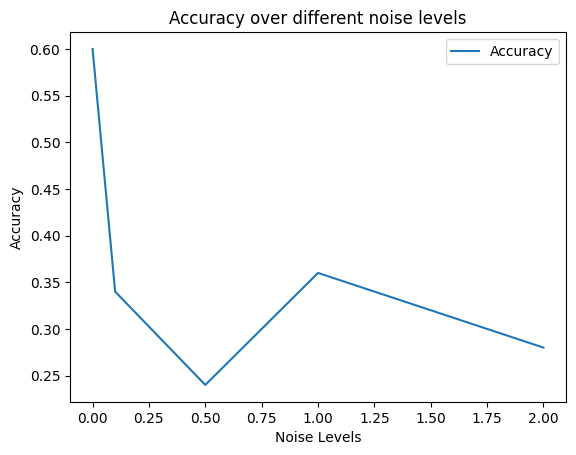

In [385]:
noise_levels = [0, 0.1, 0.5, 1.0, 2.0]
final_acc = []

for n in range(5):
    all_x, all_y = create_dataset(total_samples, adjacency_matrix, maximum_diffusion_steps=10, noise_std=noise_levels[n])
    train_dataset, val_dataset, test_dataset = create_train_val_test(graph, all_x, all_y, train_size, val_size, test_size)
    model = Net(num_communities, num_nodes, hid_features=16).to(device)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    for e in range(100):
        train_epoch(model, train_loader, optimizer)
    v_loss, acc = evaluate_epoch(model, test_loader)
    final_acc.append(acc)
    
plt.plot(noise_levels, final_acc, label='Accuracy')

plt.title('Accuracy over different noise levels')
plt.xlabel('Noise Levels')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

* What do you conclude if the noise level increases?

#### Answers:

The accuracy clearly decreases when there is noise involved.

## Effect on number of commuities

Generate data with increased number of communities and re-train your model.

Plot test accuracy versus number of communities for at least 5 values.

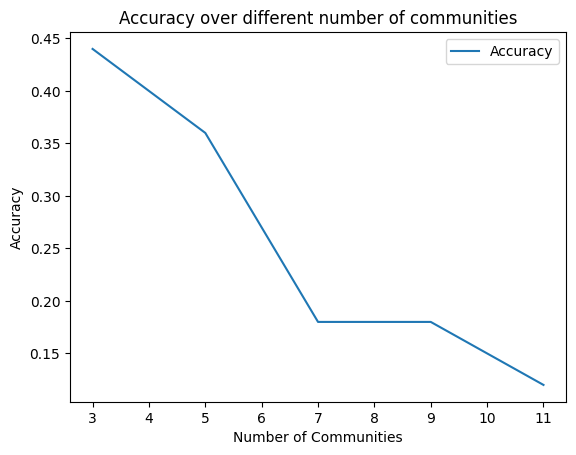

In [397]:
num_com = [3, 5, 7, 9, 11]
final_acc = []

for n in range(5):
    adjacency_matrix, labels = generate_sbm_graph(num_nodes, num_com[n], intra_prob, inter_prob, seed=42)
    all_x, all_y = create_dataset(total_samples, adjacency_matrix, labels, num_com[n], maximum_diffusion_steps=10, noise_std=0)
    train_dataset, val_dataset, test_dataset = create_train_val_test(graph, all_x, all_y, train_size, val_size, test_size)
    model = Net(num_com[n], num_nodes, hid_features=16).to(device)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    for e in range(100):
        train_epoch(model, train_loader, optimizer)
    v_loss, acc = evaluate_epoch(model, test_loader)
    final_acc.append(acc)
    
plt.plot(num_com, final_acc, label='Accuracy')

plt.title('Accuracy over different number of communities')
plt.xlabel('Number of Communities')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

* How is the performance affected by the number of communities?

#### Answers

As the community increases, the accuracy decreases.